In [1]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Load the data the old way


In [24]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


# Notebook configurations

In [25]:
DoMerge = False
LoadFromSingleFile=True
load_fixed_thresholdStuff=False
GenerateIndexes=False
InspectClasses = True
RemoveRandomPings =True

#  Data Loading Fucntions 

In [26]:
#  mapps the input records to a integer array for the input
def mapping_x( inp ):
    return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1) for x in inp ])

def mapping_x_no_direction( inp ):
    return np.array([ int(x["packet_length"])  for x in inp ])

In [27]:
def mapping_sampling_y(inp):
    return np.random.choice( np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] ))
def mapping_y(inp):
    return   np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] ) 
def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

In [28]:
import random
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 
def ShouldKeep (record) :
    
    l = len ( [ x for x in record  if x['event']=='ping' ] )
    return (l>0 and   random.random()  < 0.04) or l ==0 

def clean_data( x_data, y_data , removeempty=True, doMap=True, loadDirection=True, DoRandomRemovalOfPing =True ):
    
        
    cleans = [] 
    cleans = sorted([ x for x in y_data if  
                     (ShouldKeep(y_data[x] ) and DoRandomRemovalOfPing) 
                     or
                      (not DoRandomRemovalOfPing and (  (removeempty and len(y_data[x]) > 0) or not removeempty)) 
                    
                    ] )
    
#     cleans = sorted([ x for x in y_data if  
#                  (ShouldKeep ) 
                 
#                 ] )
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    if doMap:
        ret_x  = [ mapping_x(x) if loadDirection else mapping_x_no_direction(x) for x in ret_x ] 
        ret_y  = [ mapping_y(y) for y in ret_y ]
    
    return ret_x, ret_y



In [29]:
x= []
y= []



DoMapping  = True
DoCleaning= True

if DoMerge :
    DoMapping=False
    DoCleaning = False

path_item = "fixed" if load_fixed_thresholdStuff else "2"

if LoadFromSingleFile :
    # fname  = os.path.basename(pick)
    with open(  '../files/train/test/test_homes/final_upload/Merged_final/merged_hub_segments_final.json'  ) as f:
        y_data = json.load(f)

    with open(  '../files/train/test/test_homes/final_upload/Merged_final/merged_pcap_segments_final.json'  ) as f:
        x_data = json.load(f)
        

    if len( y_data ) != len(x_data) :
        print( pick )
    #     continue

    
    t_x,t_y= clean_data(x_data, y_data, True, DoMapping,DoRandomRemovalOfPing=True,loadDirection=False)

    x.extend(t_x)
    y.extend(t_y)
    print("loaded from single File")
    
else : 
    for pick in glob.glob('../files/train/hub_segments_%s/*.json' % path_item ):
        fname  = os.path.basename(pick)
        with open( os.path.join( '../files/train/hub_segments_%s/' % path_item, fname) ) as f:
            y_data = json.load(f)

        with open( os.path.join('../files/train/pcap_segments_%s/' % path_item, fname) ) as f:
            x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )
            continue

        t_x,t_y= clean_data( x_data, y_data, DoCleaning ,DoMapping,DoRandomRemovalOfPing=RemoveRandomPings)

        x.extend(t_x)
        y.extend(t_y)
    
x= np.array(x)
y= np.array(y)

loaded from single File


In [24]:
a= x[2]
b = x[14]

a_y = y[2]
b_y = y[14]
a,b, a_y, b_y





(array([403,  99]),
 array([118,  97, 132, 106, 209,  89, 522, 127]),
 array(['level'], dtype='<U5'),
 array(['unknown'], dtype='<U7'))

In [33]:
a[:-1]

array([403])

In [30]:
c = np.concatenate( (a[:-1],  [ b[0]], [a[-1]], b[1:]) )
c_y = np.unique( np.concatenate( ( a_y, b_y ) ))

NameError: name 'a' is not defined

In [31]:
import random
def purturb( x_inp , y_inp  ,percentage= 0.5, ignore_empty=False ):
    
    if ignore_empty :
        indexes= [ i for i in range(len(y_inp)) if  len( x_inp[i] )>1 and  'none' not in  y_inp[i]  and 'unknown'  not in y_inp[i] ]
        indexes = random.sample( indexes, percentage  )
    else :
        indexes=  [ i for i in range(len(y_inp)) if  len( x_inp[i] )>1 ]
    
    assert len(indexes)> 1
    
    pickable_len =int( len(indexes) * percentage)
    if pickable_len %2 != 0 :
        pickable_len+=1
    
    indexes =  random.sample(indexes, pickable_len)
    
    set_1 = np.array( random.sample( indexes, int(pickable_len/2) ), dtype=int )
    indexes = np.array(indexes, dtype=int)
    set_2 = np.array(  indexes[ ~np.isin(indexes, set_1) ], dtype=int )
    
    x_new = [] 
    y_new = []
    for i in range(len(set_1)):
        a= x_inp[set_1[i]]
        b= x_inp[set_2[i]]
        a_y =list( y_inp[set_1[i]])
        b_y = list(y_inp[set_2[i]])
        
        
        x_new.append(np.concatenate( (a[:-1],  [ b[0]], [a[-1]], b[1:]) ))
        y_new.append(  list(set(b_y + a_y)) ) 
    
    x_ret  = np.append(x_inp, np.array(x_new))
    y_ret  = np.append(y_inp, np.array(y_new))
    
    return x_ret, y_ret

In [32]:
import random
def purturb( x_inp , y_inp  ,percentage= 0.5, ignore_empty=False, overlap_count = 1 ):
    
    if ignore_empty :
        indexes= [ i for i in range(len(y_inp)) if  len( x_inp[i] )>overlap_count and  'none' not in  y_inp[i]  and 'unknown'  not in y_inp[i] ]
    else :
        indexes=  [ i for i in range(len(y_inp)) if  len( x_inp[i] )>overlap_count ]
    
    assert len(indexes)> overlap_count
    
    pickable_len =int( len(indexes) * percentage)
    if pickable_len %2 != 0 :
        pickable_len+=1
    
    indexes =  random.sample(indexes, pickable_len)
    
    set_1 = np.array( random.sample( indexes, int(pickable_len/2) ), dtype=int )
    indexes = np.array(indexes, dtype=int)
    set_2 = np.array(  indexes[ ~np.isin(indexes, set_1) ], dtype=int )
    
    x_new = list(x_inp) 
    y_new = list(y_inp)
    for i in range(len(set_1)):
        a= x_inp[set_1[i]]
        b= x_inp[set_2[i]]
        a_y =list( y_inp[set_1[i]])
        b_y = list(y_inp[set_2[i]])
        
        ret = [ a[:-1* overlap_count] , b[:overlap_count] ,a[-1*overlap_count:],b[overlap_count:]]
        ret  = [  i if type(i)==np.ndarray else np.array([i]) for i in ret ]      
        ret =np.array(list(np.concatenate(ret)))
#         print(a,b, ret)

        x_new.append( ret)
        y_new.append( list(set(b_y + a_y))) 

    return x_new, y_new

In [33]:
xx,yy = purturb( x[:20], y[:20] , overlap_count=2)

In [34]:
print(len(xx),len(yy))
for i in range(len(xx)):
    print( xx[i], "==>", yy[i] )
    if i == 19 :
        print("----------------")

23 23
[290  99 412  99] ==> ['colorTemperature']
[292  99 404  99 403  99] ==> ['level']
[403  99] ==> ['level']
[406  99] ==> ['unknown']
[107  99] ==> ['unknown']
[100  99] ==> ['unknown']
[131  99] ==> ['unknown']
[269  99 757  99  99] ==> ['switch']
[270  99 404 406  99  99] ==> ['switch']
[271  99 405 406  99  99] ==> ['switch']
[100  99] ==> ['switch']
[290  99 411  99] ==> ['colorTemperature']
[270  99 405 406  99  99] ==> ['switch']
[106 323 143  99  99 106  99] ==> ['unknown']
[118  97 132 106 209  89 522 127] ==> ['unknown']
[100  99] ==> ['unknown']
[131  99] ==> ['unknown']
[270  99 756  99  99] ==> ['switch']
[269  99 403 405  99  99] ==> ['switch']
[271  99 405 406  99  99] ==> ['switch']
----------------
[270  99 404 406 106 323  99  99 143  99  99 106  99] ==> ['switch', 'unknown']
[271  99 405 406 290  99  99  99 412  99] ==> ['colorTemperature', 'switch']
[270  99 405 406 269  99  99  99 403 405  99  99] ==> ['switch']


In [59]:
a= np.array([1,2,3,4,5,6,7])
s= np.array([2,3])
a[~np.isin( range(len(a)), s)]

array([1, 2, 5, 6, 7])

In [37]:
c, c_y


(array([403, 118,  99,  97, 132, 106, 209,  89, 522, 127]),
 array(['level', 'unknown'], dtype='<U7'))

In [29]:
a[:-2], b[0], a[-1], b[1:]

(array([], dtype=int64), 118, 99, array([ 97, 132, 106, 209,  89, 522, 127]))

In [26]:
c

NameError: name 'c' is not defined

In [35]:
for i in range( 6):
    print(x[i],"-->",y[i])

[290  99 412  99] --> ['colorTemperature']
[292  99 404  99 403  99] --> ['level']
[403  99] --> ['level']
[406  99] --> ['unknown']
[107  99] --> ['unknown']
[100  99] --> ['unknown']


In [ ]:
path_item

In [ ]:
if DoMerge:
    y_2 = {}
    x_2 = {}
    for i in range(len(y)):
        y_2[i+1] = y[i]
        x_2[i+1] = x[i]
        
    with open( "../files/train/merged/hub_segments_%s.json" % path_item, "w" ) as f:
        json.dump(y_2, f, indent=4)
    with open( "../files/train/merged/pcap_segments_%s.json" % path_item, "w" ) as f:
        json.dump(x_2, f, indent=4)
    
    print("Done wrintg to files!")
    

In [ ]:
if GenerateIndexes:
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    idx = []
    for train_idx, test_idx in sss.split( x,y ):
        idx.append( [train_idx,test_idx] )
        
    idx_dic  = {}
    for i in range(len(idx)) :
        pick = idx[i]
        tdic = {"test":[ int(m + 1) for m in pick[1]],
               "train":[ int(m + 1) for m in pick[0]]}
        idx_dic[i+1] = tdic 
    
    with open( "../files/train/merged/items_%s_test-train_indexes.json" % path_item, "w" ) as f:
        json.dump( idx_dic, f, indent=4 )

# Inspect Class counts

In [36]:
list(np.unique(  np.concatenate( y  )))

['acceleration',
 'activity',
 'battery',
 'button',
 'colorTemperature',
 'contact',
 'level',
 'lock',
 'motion',
 'none',
 'ping',
 'status',
 'switch',
 'temperature',
 'threeAxis',
 'unknown',
 'water']

In [40]:
ignoreMultiLabel = False
if not InspectClasses : 
    1/0
classes_dic = {}
classes_count_dic = {}
classes_non_unique_dic = {}


for item in list(np.unique( np.concatenate( y ))):
    classes_dic[item] = set([])
    classes_count_dic[item]= list()
    classes_non_unique_dic[item] = list() 
    
indices = np.arange(x.shape[0])
np.random.shuffle(indices)

# x = x[indices]
# y= y[indices]

for pick in range(0,len(y),100):
    for i in range( pick , pick+99 ):
        if i >= len(y):
            break;
            
        if( ignoreMultiLabel and len( y[i]) >1): continue
            
        for j in y[i]:   
            classes_dic[j].add( str(x[i]) )
            classes_non_unique_dic[j].append(str(x[i]))

    for item in classes_dic:
        classes_count_dic[item].append( len( classes_dic[item] ) )
     

In [ ]:
with open ( "../files/raw_charts/uniqueSigCount_fixed_service.json", "w" ) as f : 
    json.dump(classes_count_dic , f , indent=4  )

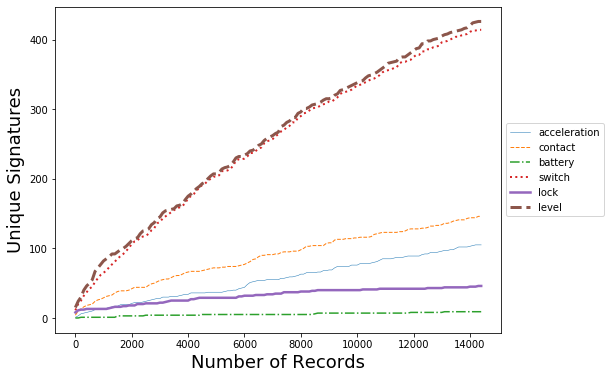

In [41]:
# with open (  "../files/raw_charts/uniqueSigCount_fixed_service_event.json") as f :
#     classes_count_dic = json.load(f )
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
marker_shapes=["",".","+","x","p","8"]
line_styles = ['-', '--', '-.', ':']
items = ["acceleration","contact","battery","switch","lock","level"]
# items = ["level-XXX","button-pushed","acceleration-inactive","threeAxis-XXX","colorTemperature-XXX","switch-on"]
for i in range( len(items) ):
# for pick in classes_count_dic:
#     if pick == "none" : continue
#     if pick not in ["","","","","",""]:
#         continue
    pick = items[i]
    
    ax1.plot(range(0,len( classes_count_dic[pick])*100,100), classes_count_dic[pick] , label=pick, linestyle=line_styles[i%4], lw=((i+1)/2)%4 )
ax1.set_ylabel('Unique Signatures',fontdict={'fontsize': 18, 'fontweight': 'medium'} )
ax1.set_xlabel('Number of Records',fontdict={'fontsize': 18, 'fontweight': 'medium'} )
# ax1.set_title ("Number of observed sequences per class as new items are observed")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [15]:
import pandas as pd

classes_count_dic['item_counts(x)'] = range(0,len( classes_count_dic[pick])*100,100)

# df= pd.DataFrame( { 'row_counts' , 
#     classes_count_dic["acceleration"],
# classes_count_dic["contact"],
# classes_count_dic["battery"],
# classes_count_dic["switch"],
# classes_count_dic["lock"],
# classes_count_dic["level"] ] ,columns= ['number of records',"acceleration","contact","battery","switch","lock","level"])

df= pd.DataFrame( classes_count_dic )

In [18]:
len(  range(0,len( classes_count_dic[pick])*100,100) )
len(  )

296

In [17]:
df.to_csv('outputs/unique_signatures_by_numberof_records.csv')

In [23]:
print("%25s -|- %8s , %10s" %( '-' , 'unique', 'total' ))
for pick in classes_count_dic:
    print( "%25s --> %8d , %10d" % (pick, classes_count_dic[pick][-1] , len( classes_non_unique_dic[pick] ))  )

                        - -|-   unique ,      total


NameError: name 'classes_non_unique_dic' is not defined

In [59]:
print("%25s -|- %8s , %10s" %( '-' , 'unique', 'total' ))
for pick in classes_count_dic:
    print( "%25s --> %8d , %10d" % (pick, classes_count_dic[pick][-1] , len( classes_non_unique_dic[pick] ))  )

                        - -|-   unique ,      total
             acceleration -->      102 ,        252
                 activity -->       19 ,         20
                  battery -->        9 ,         15
                   button -->       46 ,        331
         colorTemperature -->       35 ,        878
                  contact -->      145 ,        625
                    level -->      424 ,       2973
                     lock -->       47 ,       1064
                   motion -->       39 ,        287
                     none -->       56 ,        280
                     ping -->       10 ,        521
                   status -->      116 ,        440
                   switch -->      412 ,       1329
              temperature -->       63 ,        579
                threeAxis -->      181 ,        470
                  unknown -->      298 ,       5424
                    water -->       39 ,        121


In [60]:
 
out= np.zeros(( len(classes_count_dic) , len(classes_count_dic)  ))
labelColission = {}
classes = list(classes_count_dic.keys())
for i in range( len(classes_dic) ):
    for j in range(  len(classes_dic) ):
        out[i][j]=len ( set([ val for val in classes_dic[ classes[i] ] if val in classes_dic[classes[j]] ] ))  
        if i != j:
            labelColission["%s-%s" % ( classes[i] ,classes[j] )] = list( set([ val for val in classes_dic[ classes[i] ] if val in classes_dic[classes[j]] ] ))
none_index = classes.index('none')

out[none_index][none_index] =400
# for pick in classes_count_dic:
#     cnt  = len ( [ val for val in classes_count_dic[pick] if val in classes_count_dic["none"] ] ) 
#     print( "%s -> %d" % ( pick , cnt ) )

In [61]:
for pick in labelColission:
    if len( labelColission[pick] )>0 :
        print( pick,":",  labelColission[pick] )

acceleration-activity : ['[118  97 132 106 209  89 522 127]']
acceleration-battery : ['[411  99 411  99]', '[405  99 107  99]']
acceleration-button : ['[118  97 132 106 209  89 522 127]']
acceleration-colorTemperature : ['[118  97 132 106 209  89 522 127]', '[413  99]', '[411  99]', '[412  99]', '[410  99]']
acceleration-contact : ['[741  99  99 731  99  99 412  99]', '[102  99]', '[411  99 729  99  99]', '[730  99  99]', '[740  99  99 733  99  99 412  99]', '[411  99 101 107 728  99  99]', '[411  99 727  99  99]', '[407  99]', '[742  99  99 413  99 733  99  99]', '[405  99 406  99]', '[411  99]', '[406  99 746  99  99 732  99  99 413  99]', '[733  99  99]', '[741  99  99 730  99  99 410  99]', '[131  99]', '[741  99  99 728  99  99 413  99]', '[731  99  99]', '[405  99]', '[728  99  99 740  99  99]', '[412  99 743  99  99 731  99  99 412  99]', '[411  99 739  99  99 729  99  99  99]', '[733  99  99 412  99]', '[413  99]', '[743  99  99 732  99  99 413  99]', '[728  99  99]', '[727  99

In [62]:
classes_count_dic["motion"]

[5,
 5,
 5,
 6,
 7,
 7,
 8,
 10,
 10,
 10,
 12,
 12,
 13,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 23,
 24,
 25,
 25,
 25,
 25,
 25,
 26,
 26,
 26,
 26,
 27,
 27,
 27,
 28,
 28,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 30,
 30,
 30,
 30,
 31,
 32,
 32,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 36,
 36,
 36,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39]

In [63]:
# o2 = out.astype('float') / out.sum(axis=1)[:, np.newaxis]
# np.sum(o2,axis=1)

sum() - sum( [ out[p][p]  for p in range(len(out)) ] )
# o2

TypeError: sum expected at least 1 arguments, got 0

In [64]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, 
                         showNumbers = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.max(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure( figsize=(16,16) )
#     plt.tick_params(labelsize=10) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap )
    
    plt.rcParams.update({'font.size': 22}) 
    plt.title(title,size=30)
    plt.colorbar()
    plt.tick_params(axis='both',  labelsize=18)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=270)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    if showNumbers:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()

Confusion matrix, without normalization


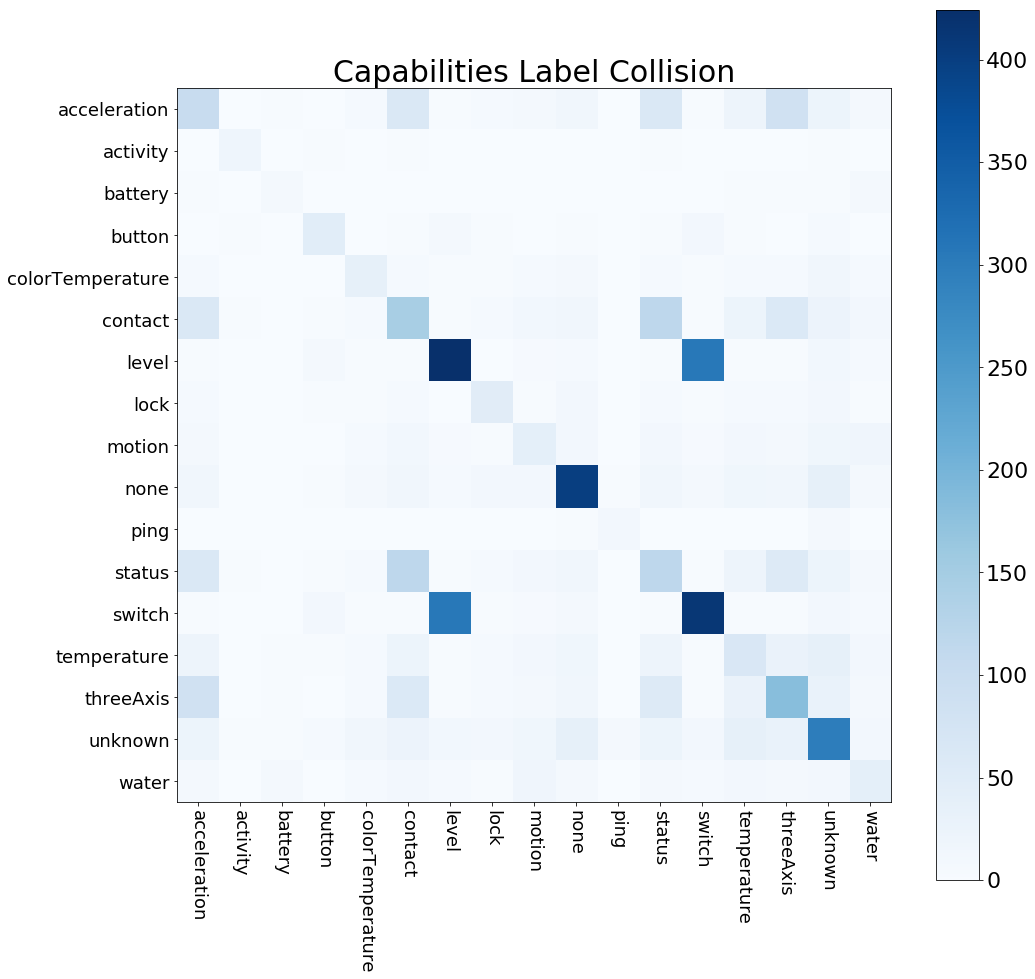

In [66]:
plot_confusion_matrix( out.astype(int), classes, normalize=False , title='Capabilities Label Collision' )

In [78]:
len(classes)

17

In [77]:
sizes = np.unique(np.concatenate( x), return_counts=True)
sums= 0 
for i in range(len(sizes[0])):
    print( "%d--> %d" % ( sizes[0][i], sizes[1][i] ) )
    if  sizes[0][i] < 1000:
        sums+= (1000-sizes[0][i] )* sizes[1][i]

print (sums)
    

65--> 1
75--> 1
78--> 55
79--> 1
82--> 25
83--> 4
85--> 115
86--> 97
87--> 105
88--> 5
89--> 1683
90--> 28
91--> 6
93--> 6
94--> 2
96--> 4
97--> 1708
98--> 17
99--> 20998
100--> 328
101--> 865
102--> 369
105--> 3
106--> 2330
107--> 1413
108--> 294
109--> 13
110--> 6
111--> 1
113--> 24
114--> 34
115--> 265
117--> 3
118--> 1687
119--> 2
120--> 2
121--> 12
122--> 12
123--> 1
124--> 459
125--> 307
126--> 6
127--> 1689
128--> 3
129--> 1
130--> 1
131--> 450
132--> 1965
133--> 1
135--> 1
136--> 5
137--> 1
138--> 2
139--> 2
142--> 1
143--> 330
145--> 5
147--> 2
148--> 2
149--> 1
150--> 3
151--> 15
152--> 6
153--> 3
154--> 8
155--> 3
157--> 1
158--> 3
159--> 12
160--> 18
161--> 11
162--> 14
163--> 1
164--> 3
165--> 1
166--> 7
168--> 1
172--> 21
173--> 1
174--> 2
175--> 12
176--> 3
177--> 6
179--> 2
180--> 4
181--> 1
182--> 1
184--> 1
187--> 5
188--> 5
189--> 36
191--> 8
192--> 1
193--> 3
194--> 1
195--> 1
201--> 1
203--> 1
209--> 1684
210--> 2
211--> 2
213--> 1
214--> 1
215--> 7
216--> 1
218-->

In [16]:
ls = np.unique([len( x[ i]) for i in range( len(x) )], return_counts=True)
for i in range(len(ls[0])):
    print( ls[0][i], ":",ls[1][i] )

1 : 305
2 : 6677
3 : 388
4 : 2190
5 : 355
6 : 1652
7 : 415
8 : 1826
9 : 104
10 : 345
11 : 13
12 : 26
13 : 9
14 : 17
15 : 9
16 : 9
17 : 3
18 : 9
19 : 1
20 : 2
21 : 2
22 : 2
23 : 2
24 : 1
25 : 3
27 : 2
29 : 1
41 : 1
42 : 1
48 : 1
49 : 2
50 : 1
51 : 2
57 : 1
68 : 1
